## Automated Stats for Linear Regression of 3x3 Matrices

Perform the right number of iterations to generate the mean for each inverse cell to be statistically different than the others with an acceptable p value with an ANOVA Test for Test 4 from previous notebook (LinearRegressionMatrixInverse.ipynb)

Keep running regressions until the p value is below 0.05 - this can be adjusted in the variables should you desire but 0.05 is the standard for a reasonable anova to determine that the mean is reasonable

We know from the previous notebook results (3x3TestResults.doc) that the 4 tests keep increasing in r squared values so there is no need to run each test. We can focus on Test 4 anyways as it has the best results and we wish to determine an r squared value for this Test that is reasonable as different sets of random matrices always generate different r squared values demonstrating the highly nonlinear properties of this problem

We need to run the regression many times as from the results of the previous notebook (LinearRegressionMatrixInverse.ipynb) we can see that the results vary significantly from different sets of matrices with randomly generated values. I will determine a mean r squared value for the Test 4 regression accross all cells.

The code from LinearRegressionMatrixInverse.ipynb is condensed and functionalized to be loopable

## Table of Contents
[1. Variables/Notebook Setup](#Step-1:-Variables/Notebook-setup) 

[2. Functions Setup](#Step-2:-Functions-Setup) <br>

[3. Test Loop Section](#Step-3:-Test-Loop-Section) <br>

[4. Results Analysis](#Step-4:-Results-Analysis) <br>

[5. Conclusion](#Step-5:-Conclusion) <br> 

## Step 1: Variables/Notebook setup

minCellValue: the minimum value of each matrix element

maxCellValue: the maximum value of each matrix element

numMatricesToGenerate: the number of matrices to use, more matrices more reliable results, but longer execution time

integersOnly: to use integers only in the tests

Advnaced setup can be done with random seed to change the starting matrix elements random values generated

In [12]:
minCellValue = 0
maxCellValue = 6
NumMatricesToGenerate = 3501
integersOnly = True
pvaluecutoff = 0.05

In [13]:
#advanced setup - can be modified for certain runs with with notebook
#mainly to test if the mean rsquared values flatten for cells
randomSeed = 99911

In [14]:
#import libraries/setup
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import statsmodels.api as sm
import scipy.stats as stats
np.random.seed(randomSeed)

In [15]:
#variables to be used throughout this notebook
matrixSize = 3
listVar = list(range(matrixSize))
inverseRangeMin = minCellValue - (maxCellValue-minCellValue)*100.0
inverseRangeMax = maxCellValue + (maxCellValue-minCellValue)*100.0

## Step 2: Functions Setup

In [16]:
#remove columns from dataframe
def dropCols(dflm):
    dflm.drop('inverse00', axis=1, inplace=True)
    dflm.drop('inverse01', axis=1, inplace=True)
    dflm.drop('inverse02', axis=1, inplace=True)
    dflm.drop('inverse10', axis=1, inplace=True)
    dflm.drop('inverse11', axis=1, inplace=True)
    dflm.drop('inverse12', axis=1, inplace=True)
    dflm.drop('inverse20', axis=1, inplace=True)
    dflm.drop('inverse21', axis=1, inplace=True)
    dflm.drop('inverse22', axis=1, inplace=True)
    dflm.drop('original', axis=1, inplace=True)
    dflm.drop('inverse', axis=1, inplace=True)

In [17]:
#generate random matrices
def getMatrices():

    matList = []
    i = 1
    while i < NumMatricesToGenerate:
        if integersOnly: 
            matList.append(np.random.randint(minCellValue, maxCellValue+1, (matrixSize, matrixSize))) 
        else:
            matList.append(np.random.uniform(minCellValue, maxCellValue+1, (matrixSize, matrixSize))) 
        i += 1
        
    return matList

In [18]:
#generate inverse matrices
def getInverses(matList):

    invList = []
    for x in matList:
        try:
            inverse = np.linalg.inv(x)
            invList.append([x, inverse])
        except np.linalg.LinAlgError:
        # Not invertible. Skip this one.
            pass
        
    return invList

In [19]:
#get dataframe of matrices and inverses
def getdf(invList):

    df = pd.DataFrame(data=invList)
    df.columns = ['original', 'inverse']
    
    return df

In [20]:
#update dataframe - this code has been verified in LinearRegressionMatrixInverse.ipynb along with the reasons 
#for running this code
def updatedf(df):
    
    for i in listVar:
        for j in listVar:
            df['original'+str(i)+str(j)] = df.apply(lambda row: row['original'][i][j], axis=1)

    for i in listVar:
        for j in listVar:
            df['inverse'+str(i)+str(j)] = df.apply(lambda row: row['inverse'][i][j], axis=1)

    #remove the extreme values we saw in LinearRegressionMatrixInverse.ipynb when generating inverse matrices
    df = df.loc[df['inverse00'] > inverseRangeMin]
    df = df.loc[df['inverse00'] < inverseRangeMax]
    df = df.loc[df['inverse01'] > inverseRangeMin]
    df = df.loc[df['inverse01'] < inverseRangeMax]
    df = df.loc[df['inverse02'] > inverseRangeMin]
    df = df.loc[df['inverse02'] < inverseRangeMax]
    df = df.loc[df['inverse10'] > inverseRangeMin]
    df = df.loc[df['inverse10'] < inverseRangeMax]
    df = df.loc[df['inverse11'] > inverseRangeMin]
    df = df.loc[df['inverse11'] < inverseRangeMax]
    df = df.loc[df['inverse12'] > inverseRangeMin]
    df = df.loc[df['inverse12'] < inverseRangeMax]
    df = df.loc[df['inverse20'] > inverseRangeMin]
    df = df.loc[df['inverse20'] < inverseRangeMax]
    df = df.loc[df['inverse21'] > inverseRangeMin]
    df = df.loc[df['inverse21'] < inverseRangeMax]
    df = df.loc[df['inverse22'] > inverseRangeMin]
    df = df.loc[df['inverse22'] < inverseRangeMax]

    #generate test 4 parameters
    for i in listVar:
        for j in listVar:
            df['original00x'+str(i)+str(j)] = df.apply(lambda row: row['original'][i][j] * row['original'][0][0] * row['original'][0][0] , axis=1)

    for i in listVar:
        for j in listVar:
            df['original01x'+str(i)+str(j)] = df.apply(lambda row: row['original'][i][j] * row['original'][0][1] * row['original'][0][1], axis=1)

    for i in listVar:
        for j in listVar:
            df['original02x'+str(i)+str(j)] = df.apply(lambda row: row['original'][i][j] * row['original'][0][2] * row['original'][0][2], axis=1)

    for i in listVar:
        for j in listVar:
            df['original10x'+str(i)+str(j)] = df.apply(lambda row: row['original'][i][j] * row['original'][1][0] * row['original'][1][0], axis=1)

    for i in listVar:
        for j in listVar:
            df['original11x'+str(i)+str(j)] = df.apply(lambda row: row['original'][i][j] * row['original'][1][1] * row['original'][1][1], axis=1)

    for i in listVar:
        for j in listVar:
            df['original12x'+str(i)+str(j)] = df.apply(lambda row: row['original'][i][j] * row['original'][1][2] * row['original'][1][2], axis=1)

    for i in listVar:
        for j in listVar:
            df['original20x'+str(i)+str(j)] = df.apply(lambda row: row['original'][i][j] * row['original'][2][0] * row['original'][2][0], axis=1)

    for i in listVar:
        for j in listVar:
            df['original21x'+str(i)+str(j)] = df.apply(lambda row: row['original'][i][j] * row['original'][2][1] * row['original'][2][1], axis=1)

    for i in listVar:
        for j in listVar:
            df['original22x'+str(i)+str(j)] = df.apply(lambda row: row['original'][i][j] * row['original'][2][2] * row['original'][1][2], axis=1)
      
    return df

In [21]:
#create a results dataframe
def createResultsDf():
    return pd.DataFrame(columns=['cell00', 'cell01', 'cell02','cell10', 'cell11', 'cell12','cell20', 'cell21', 'cell22'])

## Step 3: Test Loop Section

In [22]:
#Code for generating results
#run the Test4 fit code successively until a p value <=0.05 is generated from the result set
#compile all results into df_results dataframe for analysis
index=0
pvalue = 999
df_results = createResultsDf()

while(True):
    
    #random seed is fixed at top so new matrices will be new generated values
    
    matList = getMatrices()
    
    invList = getInverses(matList)
    
    df = getdf(invList)
    
    df = updatedf(df)
    
    test4fit = []

    #get rsquared value for the linear regression
    for i in listVar:
        for j in listVar:
            dfl = df.copy()
            y = dfl['inverse'+str(i)+str(j)]
            dropCols(dfl)
            X = dfl[dfl.columns]
            X_withconstant = sm.add_constant(X)
            lm = sm.OLS(y,X_withconstant)
            fit4 = lm.fit()
            test4fit.append(fit4.rsquared)
            
    #concatenate the results
    if index>0:
        s_row = pd.Series(test4fit, index=df_results.columns)
        df_results = pd.concat([df_results, s_row.to_frame().T])
        data = []
        for x in df_results.columns:
            data.append(df_results[x])

        a,p = stats.f_oneway(*data)
        print('iteration: ' + str(index) + '     ' + 'pvalue: ' + str(p))
        if(p<=pvaluecutoff):
            pvalue = p
            break
            
    index = index + 1

C:\Users\User\anaconda3\Lib\site-packages\scipy\stats\_stats_py.py:4141: DegenerateDataWarning: all input arrays have length 1.  f_oneway requires that at least one input has length greater than 1.
  warnings.warn(stats.DegenerateDataWarning(msg))


iteration: 1     pvalue: nan
iteration: 2     pvalue: 0.8138990821507781
iteration: 3     pvalue: 0.6090767166341919
iteration: 4     pvalue: 0.6854056317953394
iteration: 5     pvalue: 0.6107379239694428
iteration: 6     pvalue: 0.6720838748951641
iteration: 7     pvalue: 0.6775249974146156
iteration: 8     pvalue: 0.8784417105273615
iteration: 9     pvalue: 0.7367885232048015
iteration: 10     pvalue: 0.6946099014370724
iteration: 11     pvalue: 0.5988044984503317
iteration: 12     pvalue: 0.5432712359666927
iteration: 13     pvalue: 0.3464405850275156
iteration: 14     pvalue: 0.3754856168212712
iteration: 15     pvalue: 0.3673185652262792
iteration: 16     pvalue: 0.2959244276745973
iteration: 17     pvalue: 0.34433977627047213
iteration: 18     pvalue: 0.3794152438313576
iteration: 19     pvalue: 0.28317256333638424
iteration: 20     pvalue: 0.4206195558691897
iteration: 21     pvalue: 0.33690071956461987
iteration: 22     pvalue: 0.1520127133774178
iteration: 23     pvalue: 0.174

<b><font style='color:blue'>Interesting how the p value does not always decrease with more data, this demonstrates the highly nonlinear aspects of test 4 linear regressions on this dataset for the various inverse cells. The warning is expected as we cannot check stats when there is only one data group</font></b>

## Step 4: Results Analysis

In [23]:
df_results.describe()

,cell00,cell01,cell02,cell10,cell11,cell12,cell20,cell21,cell22
count,28.000000,28.000000,28.000000,28.000000,28.000000,28.000000,28.000000,28.000000,28.000000
mean,0.045511,0.043836,0.046612,0.048092,0.044894,0.044404,0.044387,0.044473,0.042180
std,0.007784,0.005138,0.005769,0.005169,0.006725,0.006130,0.005355,0.008815,0.004721
min,0.033163,0.032840,0.036707,0.040538,0.031779,0.032895,0.037419,0.029372,0.031658
25%,0.040634,0.040772,0.042096,0.044957,0.040942,0.040556,0.041192,0.039645,0.039780
50%,0.044477,0.044000,0.047621,0.047762,0.044244,0.043974,0.043282,0.043175,0.042367
75%,0.050223,0.047503,0.050642,0.050584,0.049717,0.048463,0.045878,0.047197,0.045347
max,0.063322,0.053971,0.059288,0.063421,0.058864,0.059637,0.057235,0.067461,0.050212


<b><font style='color:blue'>This table shows the mean and standard deviations for each cell - the RSquared values are specified</font></b>

In [24]:
print('The p value for these results is: '+ str(pvalue))

The p value for these results is: 0.047695079894272754


In [25]:
print('rsquared means for cells:\n' + str(df_results.mean()), '\n\nrsquared standard deviations for cells:\n' + str(df_results.std()))

rsquared means for cells:
cell00    0.045511
cell01    0.043836
cell02    0.046612
cell10    0.048092
cell11    0.044894
cell12    0.044404
cell20    0.044387
cell21    0.044473
cell22    0.042180
dtype: float64 

rsquared standard deviations for cells:
cell00    0.007784
cell01    0.005138
cell02    0.005769
cell10    0.005169
cell11    0.006725
cell12    0.006130
cell20    0.005355
cell21    0.008815
cell22    0.004721
dtype: float64


<Axes: title={'center': 'Mean RSquared Value for each cell - 3501 matrices\nminCellValue: 0 maxCellValue: 6 number of iterations: 29\nrandomSeed: 99911'}, xlabel='Cell', ylabel='RSquared'>

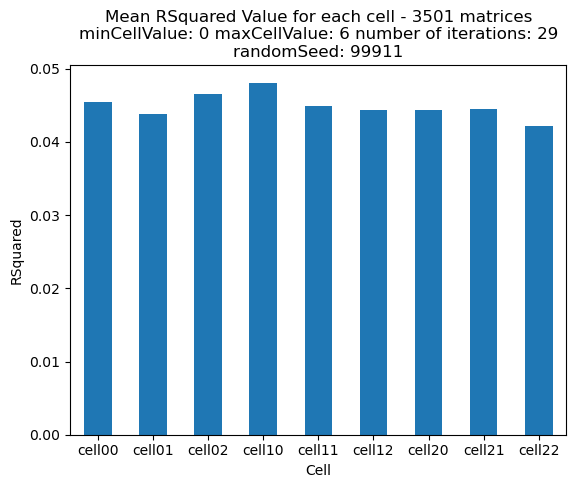

In [26]:
df_results.mean().plot(kind='bar', title = 'Mean RSquared Value for each cell - '+str(NumMatricesToGenerate)+' matrices\nminCellValue: '+str(minCellValue)+' maxCellValue: '+str(maxCellValue)+' number of iterations: '+str(index+1)+'\nrandomSeed: '+str(randomSeed), ylabel='RSquared', xlabel='Cell', rot=0)

<Axes: title={'center': 'Standard Deviation of RSquared for Each Cell - 3501 matrices\nminCellValue: 0 maxCellValue: 6 number of iterations: 29\nrandomSeed: 99911'}, xlabel='Cell', ylabel='RSquared Standard Deviation'>

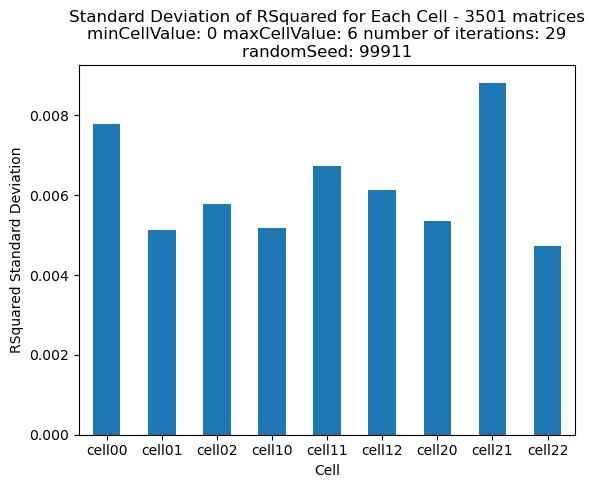

In [27]:
df_results.std().plot(kind='bar', title='Standard Deviation of RSquared for Each Cell - '+str(NumMatricesToGenerate)+' matrices\nminCellValue: '+str(minCellValue)+' maxCellValue: '+str(maxCellValue)+' number of iterations: '+str(index+1)+'\nrandomSeed: '+str(randomSeed), ylabel='RSquared Standard Deviation', xlabel='Cell', rot=0)

In [28]:
print('The RSquared value accross all cells is '+ str(df_results.mean().mean()) + ' - '+str(NumMatricesToGenerate)+' matrices - minCellValue: '+str(minCellValue)+' maxCellValue: '+str(maxCellValue)+' randomSeed: '+str(randomSeed))

The RSquared value accross all cells is 0.04493217382821743 - 3501 matrices - minCellValue: 0 maxCellValue: 6 randomSeed: 99911


## Step 5: Conclusion

<b><font style='color:blue'>The p value tells us that the means are valid and we can reject the null hypothesis, meaning there is enough data to justify this mean<br><br>These are the mean and standard deviation of the R Squared values I can achieve for each cell for test 4<br><br>They are not big enough for a suitiable linear regression so there is no need to make a model<br><br>I will move on to Neural Networks for a better model</font></b>

<b><font style='color:red'>I have compiled various results for different min max values, and number of matrices. PLease see AutomatedTesting.pdf</font></b>